<a href="https://colab.research.google.com/github/isaacye/SS2020_ML_Day2/blob/master/Session_4/Lab4A_MNIST_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print(torch.__version__)

1.5.0+cu101


##**Data preparation**

In [2]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn


batch_size = 128
train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_dataset =  datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
50000 10000 10000


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


##**Checking input data**

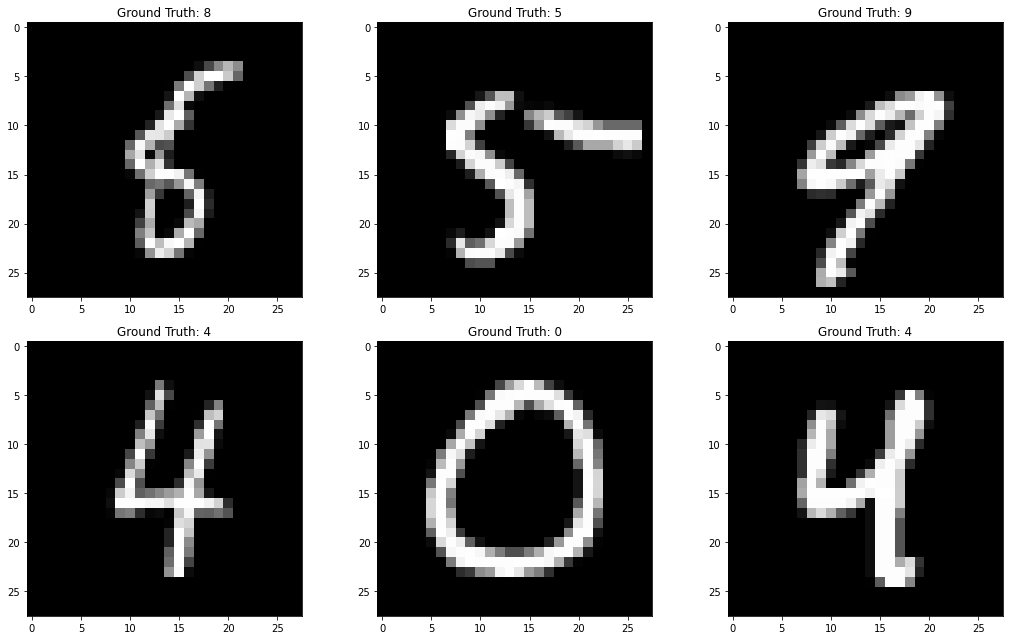

In [3]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)  

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 9))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt.show()

##**Model(Hypothesis) Define**

In [0]:
class MLPModel(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim): 
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_dim, hid_dim)
        self.linear2 = nn.Linear(hid_dim, out_dim)
        self.act = nn.ReLU()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.act(x)
        x = self.linear2(x)
        return x

##**Cost(Loss) Function**

In [0]:
cls_loss = nn.CrossEntropyLoss()

##**Training & Evaluation**

In [6]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
import time

# ====== Construct Model ====== #
model = MLPModel(784,10,200)

# ====== GPU selection ======= #
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model.to(device)

print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# ===== Construct Optimizer ====== #
lr = 0.005 
optimizer = optim.SGD(model.parameters(), lr=lr) 

list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 30
for i in range(epoch):
    ts = time.time()
    # ====== Train ====== #
    train_loss = 0
    model.train() 
    optimizer.zero_grad() 
    
    for input_X, true_y in train_loader:
        input_X = input_X.squeeze() # dropping first dimension of input_X
        input_X = input_X.view(-1, 784) # 28x28 reshaped to 1 dmin of 784

        # ====== GPU ====== #
        input_X = input_X.to(device)   # send to GPU
        true_y = true_y.to(device) # send to GPU

        pred_y = model(input_X)

        loss = cls_loss(pred_y.squeeze(), true_y)
        loss.backward() 
        optimizer.step() 
        train_loss += loss.item()  # loss.item has detach + cpu
    train_loss = train_loss / len(train_loader)
    list_train_loss.append(train_loss)
    list_epoch.append(i)
    
    
    # ====== Validation ====== #
    val_loss = 0
    model.eval()
    optimizer.zero_grad()
    
    for input_X, true_y in val_loader:
        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)

        # ====== GPU ====== #
        input_X = input_X.to(device)
        true_y = true_y.to(device)

        pred_y = model(input_X)

        loss = cls_loss(pred_y.squeeze(), true_y)
        val_loss += loss.item() # loss.item has detach + cpu
    val_loss = val_loss / len(val_loader)
    list_val_loss.append(val_loss)


    # ====== Evaluation ======= #
    correct = 0
    model.eval()
    optimizer.zero_grad()

    for input_X, true_y in test_loader:
        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)

        # ====== GPU ====== #
        input_X = input_X.to(device)
        true_y = true_y.to(device)

        pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
        correct += pred_y.eq(true_y).sum()

    acc = correct.item() / len(test_loader.dataset) #item 
    list_acc.append(acc)
    list_acc_epoch.append(i)
    
    te = time.time()
    
    print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}%, {:3.1f}'.format(i, train_loss, val_loss, acc*100, te-ts))

Number of 159010 parameters
Epoch: 0, Train Loss: 0.9025143335008865, Val Loss: 0.5889096386447737, Test Acc: 89.57000000000001%, 16.8
Epoch: 1, Train Loss: 0.42847673436793526, Val Loss: 0.5258503792029393, Test Acc: 89.89%, 16.6
Epoch: 2, Train Loss: 0.3384588154799798, Val Loss: 0.42595251659049266, Test Acc: 91.66%, 16.8
Epoch: 3, Train Loss: 0.2957341118198831, Val Loss: 0.4808923892582519, Test Acc: 91.24%, 16.8
Epoch: 4, Train Loss: 0.29807698314109116, Val Loss: 0.41366113948671124, Test Acc: 91.97999999999999%, 16.7
Epoch: 5, Train Loss: 0.24585936217547377, Val Loss: 0.36751286364808866, Test Acc: 93.31%, 16.7
Epoch: 6, Train Loss: 0.20706015058776453, Val Loss: 0.3614116375204883, Test Acc: 93.15%, 16.7
Epoch: 7, Train Loss: 0.19110273838500538, Val Loss: 0.32165947471615636, Test Acc: 93.84%, 16.7
Epoch: 8, Train Loss: 0.1771731345349794, Val Loss: 0.3171176136577431, Test Acc: 94.23%, 16.6
Epoch: 9, Train Loss: 0.16244631194893053, Val Loss: 0.3054620447698273, Test Acc: 9

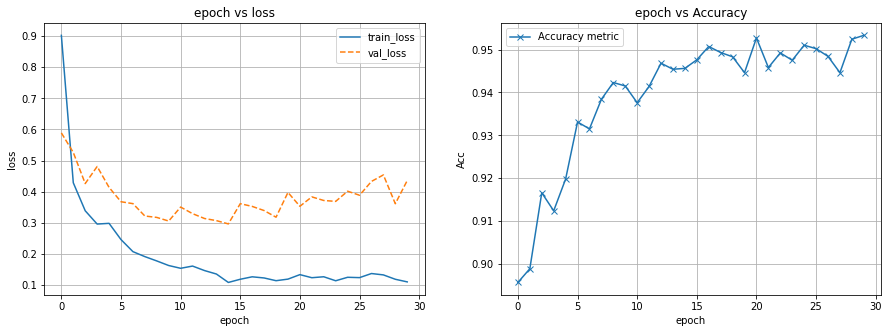

In [8]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()